# Combinatorial library vs. KLIFS

## Aim of this notebook

In this notebook we want to compare the combinatorial library to the original KLIFS ligands, i.e. the ligands from which the fragment library originates from:

1. Which recombined ligands have exact matches in the original KLIFS ligands?
2. Which recombined ligands have substructure matches in the original KLIFS ligands?

Note that the combinatorial library is stored as `json` file (~6M molecules). The data needed for this notebook was extracted previously in notebook `4_1_combinatorial_library_data.ipynb` for easy and fast access here.

## Table of contents

1. Original ligands
2. Reduced fragment library
3. Exact matches
4. Substructure matches

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path

import ijson
import pandas as pd
from rdkit import Chem
from rdkit.Chem import Draw, PandasTools

from utils import read_fragment_library, construct_ligand

In [3]:
# Needed to display ROMol images in DataFrames
PandasTools.RenderImagesInAllDataFrames(images=True)

## 1. Original ligands

In [4]:
original_ligands = pd.read_json('../data/fragment_library/original_ligands.json')
original_ligands['ROMol'] = original_ligands.inchi.apply(Chem.MolFromInchi)
print(f'Number of original ligands: {original_ligands.shape[0]}')

Number of original ligands: 2553


,complex_pdb,ligand_pdb,subpocket,kinase,family,group,alt,chain,ac_helix,smiles,inchi,ROMol
0,1a9u,SB2,"[AP, GA, B2]",p38a,MAPK,CMGC,,A,out-like,C[S@](=O)c1ccc(-c2nc(-c3ccc(F)cc3)c(-c3ccncc3)...,InChI=1S/C21H16FN3OS/c1-27(26)18-8-4-16(5-9-18...,
1,1agw,SU2,"[AP, SE]",FGFR1,FGFR,TK,B,B,out-like,O=CN1CCN(c2ccc(C[C@@H]3C(=O)Nc4ccccc43)cc2)CC1,InChI=1S/C20H21N3O2/c24-14-22-9-11-23(12-10-22...,

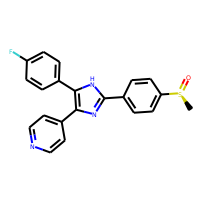
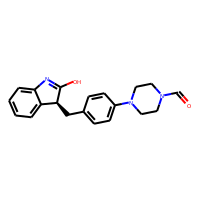

In [5]:
original_ligands.head(2)

In [6]:
print(f'Number of deduplicated ligand structures (based on InChI): {original_ligands.drop_duplicates("inchi").shape[0]}')
print(f'Number of deduplicated ligands (based on ligand PDB): {original_ligands.drop_duplicates("ligand_pdb").shape[0]}')

Number of deduplicated ligand structures (based on InChI): 2198
Number of deduplicated ligands (based on ligand PDB): 2185


## 2. Reduced fragment library

In [7]:
fragment_library = read_fragment_library(Path('../data/fragment_library_reduced/'))
fragment_library.keys()

dict_keys(['AP', 'FP', 'SE', 'GA', 'B1', 'B2'])

Loading this dataset is important in case we want to reconstruct a recombined ligand from its fragment and bond IDs.

## 3. Exact matches

Get recombined ligands in combinatorial library that have exact matches in the KLIFS original ligands.

### Load exact matches

In [8]:
exact_matches = pd.read_json('../data/combinatorial_library/original_exact.json')

In [9]:
exact_matches['ROMol'] = exact_matches.inchi.apply(Chem.MolFromInchi)

### Number of exact matches

In [10]:
print(f'Number of exact matches in KLIFS original ligands: {exact_matches.shape[0]}')

Number of exact matches in KLIFS original ligands: 35


In theory, we should be able to reconstruct 53 original ligands (see analysis in `3_2_fragment_library_reduced_original_ligands.ipynb`). These 53 ligands already refer to those original ligands that are fully covered by the reduced fragment library but do not have more than 4 subpockets and always contain an AP fragment (these are recombination criteria).

Why are not all possible ligands reconstructed? TBA

### Merge combinatorial library data (fragment/bond IDs) with original ligands data (structure metadata)

Show both ROMol molecules from the `exact_matches` and `original_ligands` dataset to make sure you have the same protonation state for both datasets (`exact_matches` was inferred from the `original_ligands`, so they must match).

In [11]:
exact_matches.columns

Index(['bond_ids', 'fragment_ids', 'hba', 'hbd', 'mwt', 'logp', 'n_atoms',
       'chembl_exact', 'original_exact', 'original_substructure', 'inchi',
       'ROMol'],
      dtype='object')

In [12]:
original_ligands.columns

Index(['complex_pdb', 'ligand_pdb', 'subpocket', 'kinase', 'family', 'group',
       'alt', 'chain', 'ac_helix', 'smiles', 'inchi', 'ROMol'],
      dtype='object')

In [13]:
# Get fragmentation details from exact_matches and kinase/structure details from orginal_ligands (keep both ROMol to check if the same)
exact_matches = pd.merge(
    exact_matches.drop(['hba', 'hbd', 'mwt', 'logp', 'n_atoms', 'chembl_exact', 'original_exact', 'original_substructure'], axis=1), 
    original_ligands.drop(['smiles', 'subpocket'], axis=1), 
    on='inchi', 
    how='left'
).drop('inchi', axis=1)

,bond_ids,fragment_ids,ROMol_x,complex_pdb,ligand_pdb,kinase,family,group,alt,chain,ac_helix,ROMol_y
0,"[[SE_10, AP_9], [FP_10, AP_8]]","[FP_14, SE_22, AP_95]",,4hgl,0YO,CK1g3,CK1,CK1,,A,in,
45,"[[SE_12, AP_8], [AP_7, FP_7]]","[FP_47, SE_103, AP_14]",,3sw7,19K,CDK2,CDK,CMGC,A,A,out,
13,"[[FP_13, AP_11]]","[FP_148, AP_5]",,4eoi,1RO,CDK2,CDK,CMGC,B,C,in,
14,"[[FP_13, AP_11]]","[FP_148, AP_5]",,4eol,1RO,CDK2,CDK,CMGC,A,A,in,
15,"[[FP_13, AP_11]]","[FP_148, AP_5]",,4eon,1RO,CDK2,CDK,CMGC,A,A,in,
16,"[[FP_13, AP_11]]","[FP_148, AP_5]",,4eop,1RO,CDK2,CDK,CMGC,B,A,in,
17,"[[FP_13, AP_11]]","[FP_148, AP_5]",,4eos,1RO,CDK2,CDK,CMGC,A,C,in,
27,"[[GA_14, AP_11], [B1_7, GA_13]]","[GA_77, B1_10, AP_62]",,4m7i,27D,PEK,PEK,Other,,A,out,
7,"[[FP_15, AP_10]]","[AP_86, FP_31]",,4mk0,29X,BARK1,GRK,AGC,B,A,in,
12,"[[FP_7, AP_14]]","[AP_103, FP_37]",,5aut,2AN,DAPK1,DAPK,CAMK,,A,in,

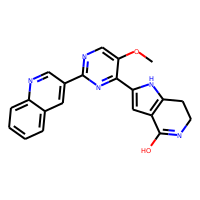
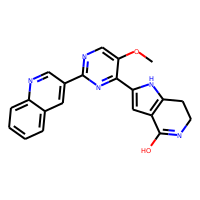
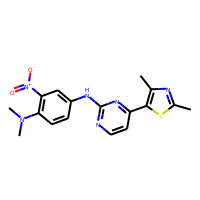
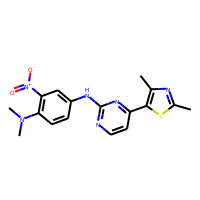
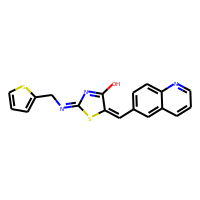
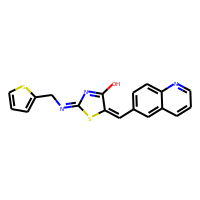
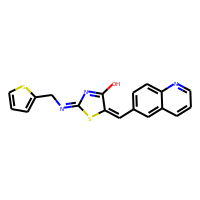
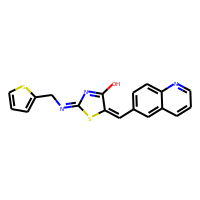
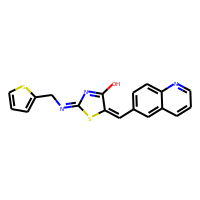
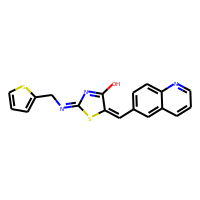
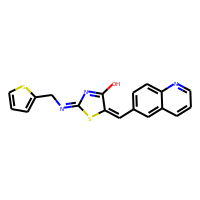
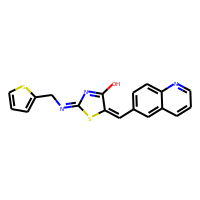
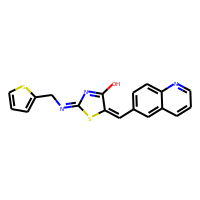
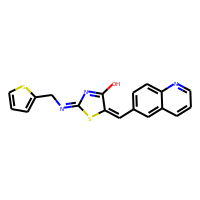
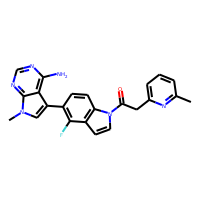
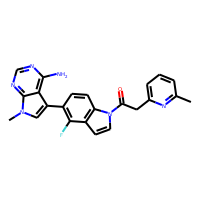
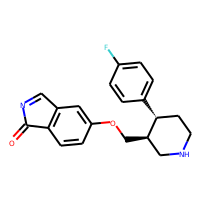
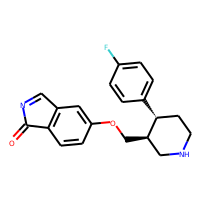
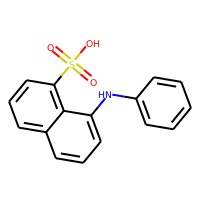
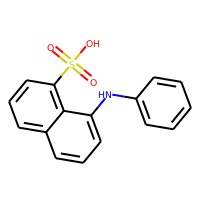
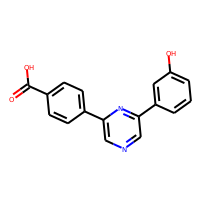
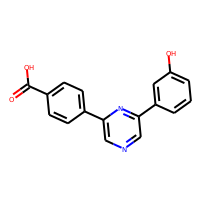
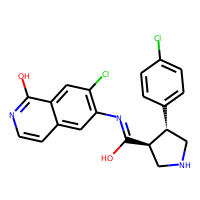
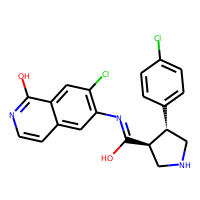
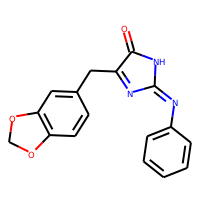
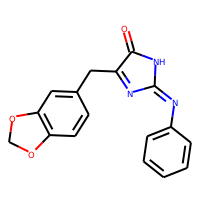
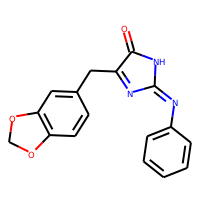
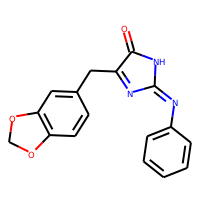
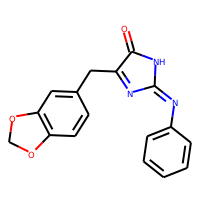
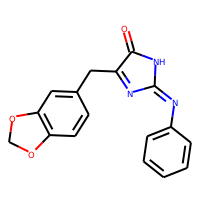
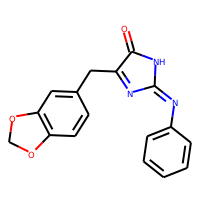
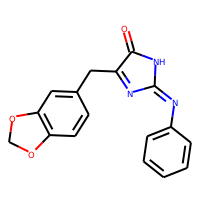
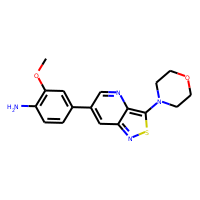
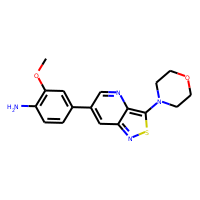
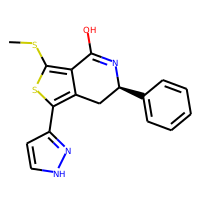
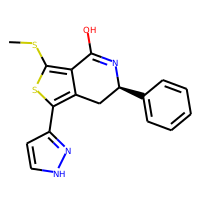
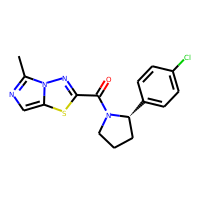
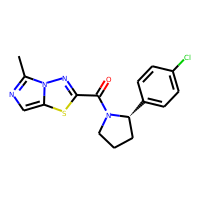
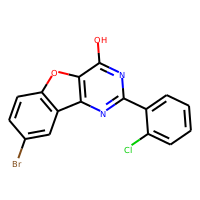
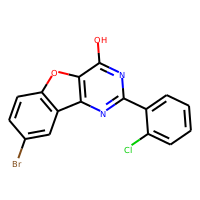
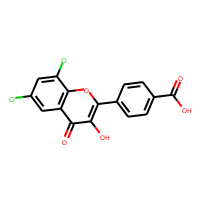
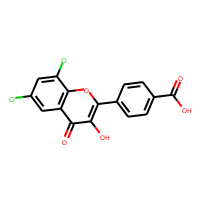
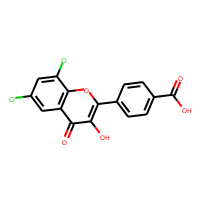
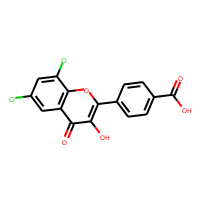
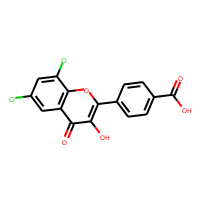
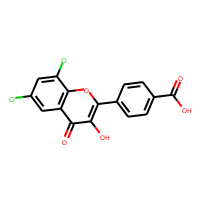
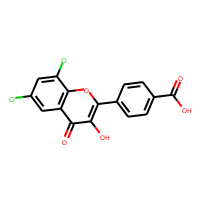
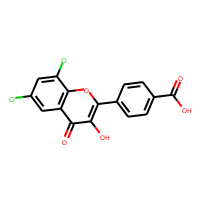
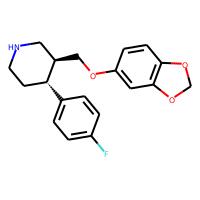
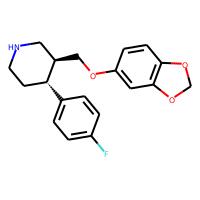
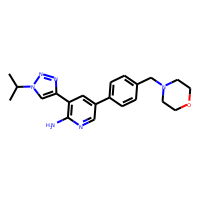
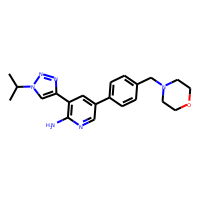
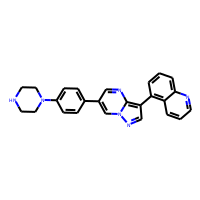
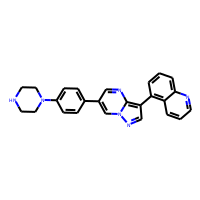
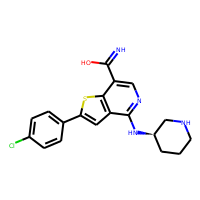
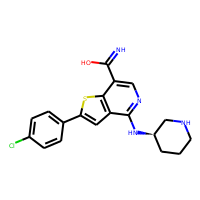
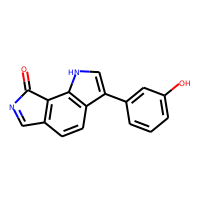
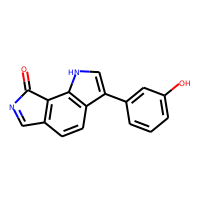
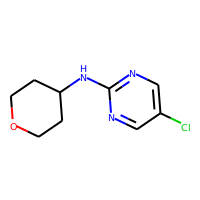
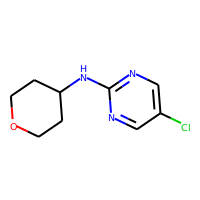
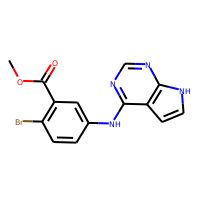
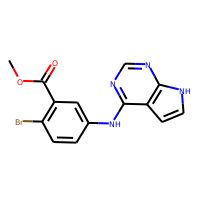
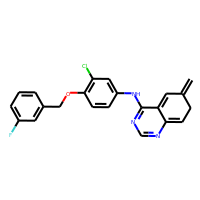
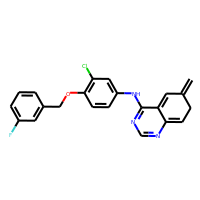
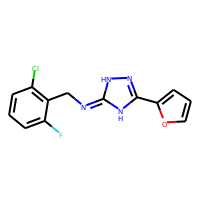
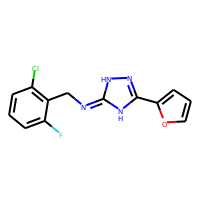
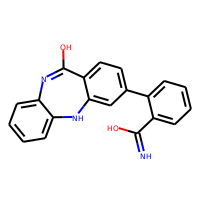
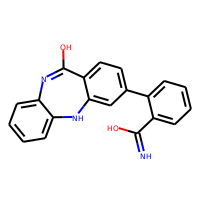
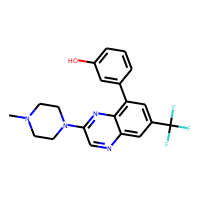
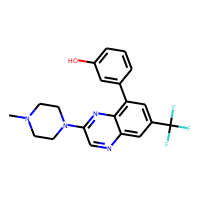
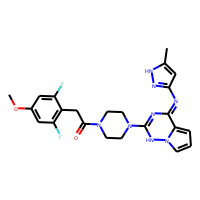
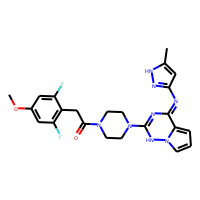
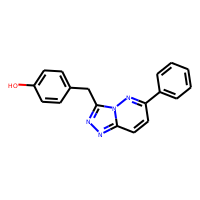
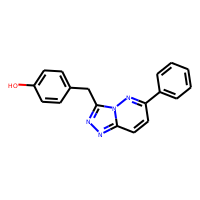
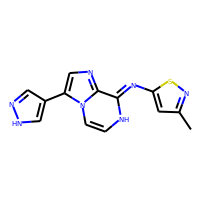
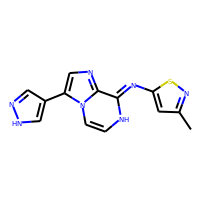
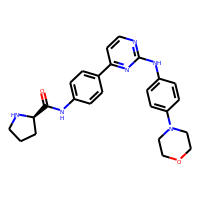
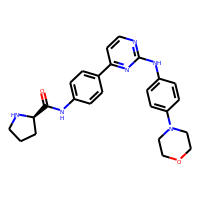
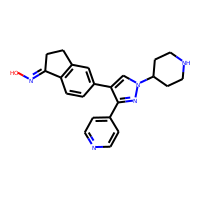
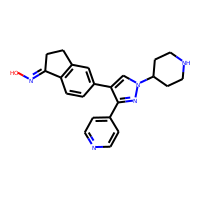
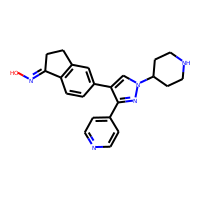
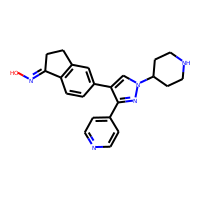
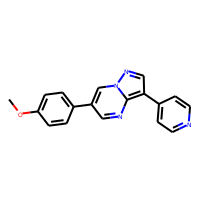
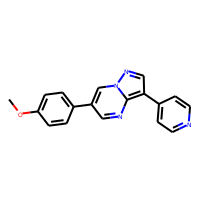
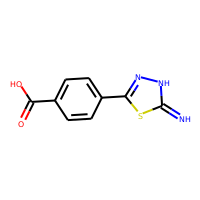
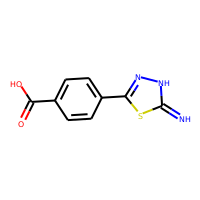
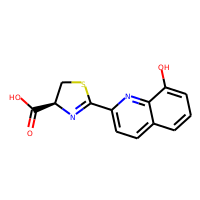
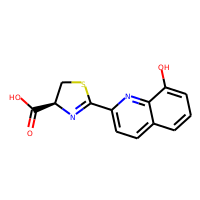
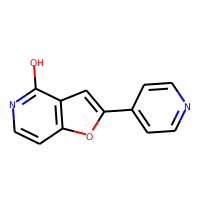
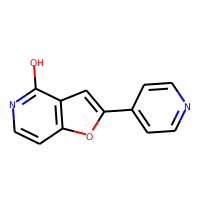
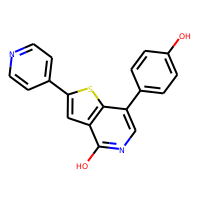
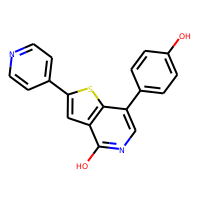

In [14]:
# Sort DataFrame by ligand_pdb, kinase group, kinase family, kinase, complex_pdb
exact_matches.sort_values(
    by=['ligand_pdb', 'group', 'family', 'kinase', 'complex_pdb'], 
    inplace=True
)

exact_matches

### Construct recombined ligands (from fragment/bond IDs)

In [15]:
exact_matches.columns

Index(['bond_ids', 'fragment_ids', 'ROMol_x', 'complex_pdb', 'ligand_pdb',
       'kinase', 'family', 'group', 'alt', 'chain', 'ac_helix', 'ROMol_y'],
      dtype='object')

kinase group | kinase name | complex PDB | ligand PDB


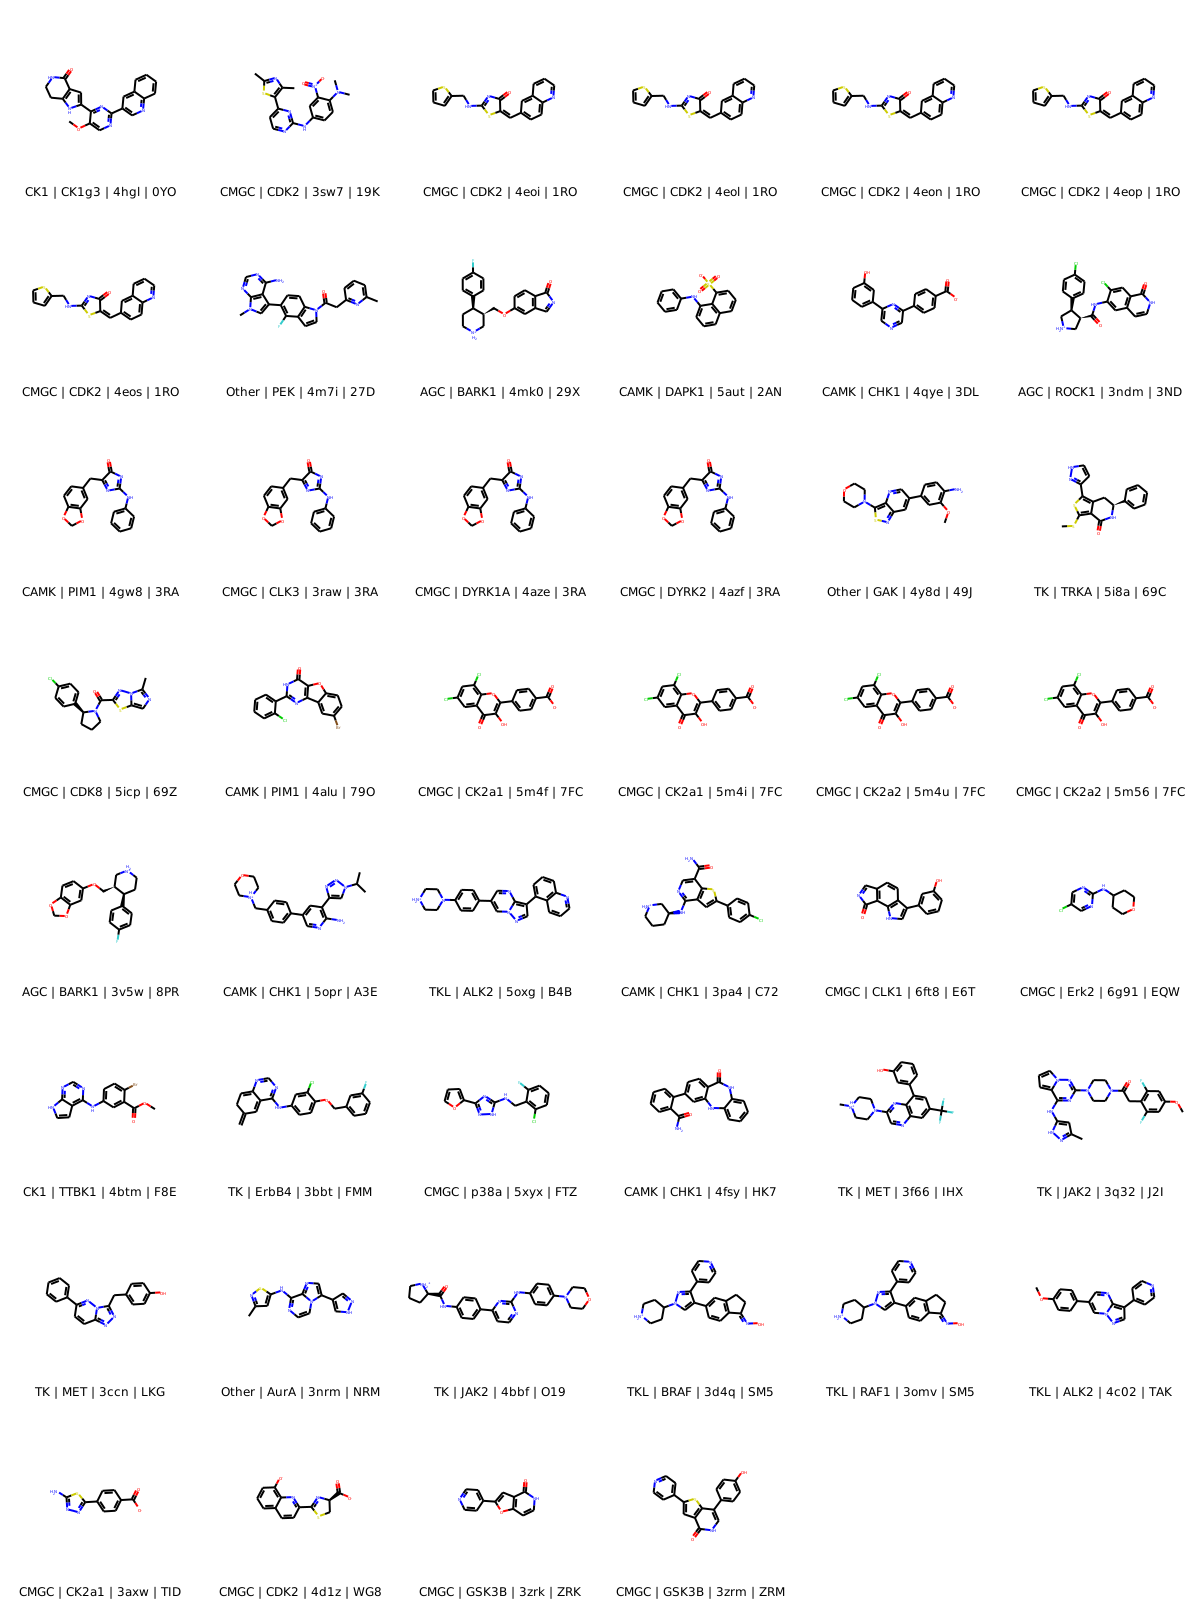

In [16]:
print(f'kinase group | kinase name | complex PDB | ligand PDB')

Draw.MolsToGridImage(
    mols=[construct_ligand(row.fragment_ids, row.bond_ids, fragment_library) for index, row in exact_matches.iterrows()], 
    legends=[f'{row.group} | {row.kinase} | {row.complex_pdb} | {row.ligand_pdb}' for index, row in exact_matches.iterrows()],
    molsPerRow=6
)

## 3. Substructure matches

Get recombined ligands in combinatorial library that have substructure matches in the KLIFS original ligands.

### Load substructure matches

In [17]:
substructure_matches = pd.read_json('../data/combinatorial_library/original_substructure.json')
substructure_matches['ROMol'] = substructure_matches.inchi.apply(Chem.MolFromInchi)

### Number of substructure matches

In [18]:
print(f'Number of substructure matches: {substructure_matches.shape[0]}')

Number of substructure matches: 325


,bond_ids,fragment_ids,hba,hbd,mwt,logp,n_atoms,chembl_exact,original_exact,original_substructure,inchi,ROMol
0,"[[GA_4, FP_7], [SE_10, AP_8], [FP_6, AP_7]]","[SE_18, AP_14, GA_40, FP_3]",1,1,1,1,26,0,0,1,InChI=1S/C18H23N5O3/c1-25-14-6-5-13(10-15(14)2...,
1,"[[FP_8, AP_7], [SE_7, AP_8], [GA_6, FP_7]]","[GA_45, SE_27, FP_128, AP_14]",1,1,1,1,27,0,0,1,InChI=1S/C21H23N5O/c22-15-8-10-16(11-9-15)25-2...,

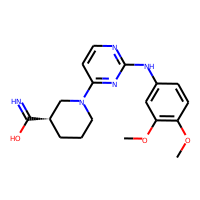
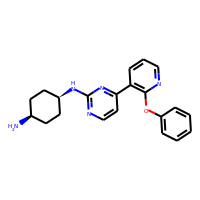

In [19]:
substructure_matches.head(2)

### Highlight recombined ligands as substructures in original ligands

In [20]:
def highlight_recombined_ligand_substructure_in_original_ligand(substructure_matches, original_ligands):
    """
    Highlight recombined ligands as substructures in original ligands.
    
    Parameters
    ----------
    substructure_matches : pandas.DataFrame
        Recombined ligands that have substructures in original ligands.
    original_ligands : pandas.DataFrame
        Original ligands.
    """

    substructure_details = []

    for i, recombined_ligand in substructure_matches.iterrows():
        for j, original_ligand in original_ligands.iterrows():

            template = original_ligand.ROMol
            pattern = recombined_ligand.ROMol
            match = template.HasSubstructMatch(pattern)

            if match:
                substructure = template.GetSubstructMatch(pattern)
                substructure_details.append([i, pattern, j, template, original_ligand.ligand_pdb])
                
    substructure_details = pd.DataFrame(
        substructure_details, 
        columns=[
            'recombined_ligand_index', 
            'recombined_ligand', 
            'original_ligand_index', 
            'original_ligand_with_substructure', 
            'ligand_pdb'
        ]
    )
    
    return substructure_details

In [21]:
# Takes 1-2 minutes
substructure_details = highlight_recombined_ligand_substructure_in_original_ligand(substructure_matches, original_ligands)

,recombined_ligand_index,recombined_ligand,original_ligand_index,original_ligand_with_substructure,ligand_pdb
0,0,,1116,,0JF
1,0,,1190,,NZF

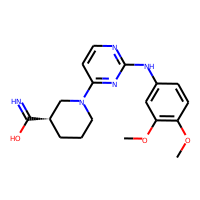
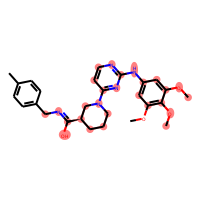
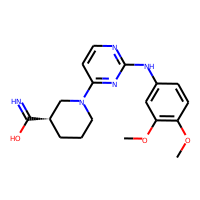
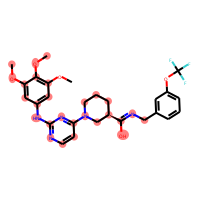

In [22]:
substructure_details.head(2)

### Number of original ligands having the same recombined ligand as substructure

In [23]:
recombined_in_original_size = substructure_details.groupby('recombined_ligand_index').size()

Text(0.5, 0, 'Number of original ligands having the same recombined ligand as substructure')

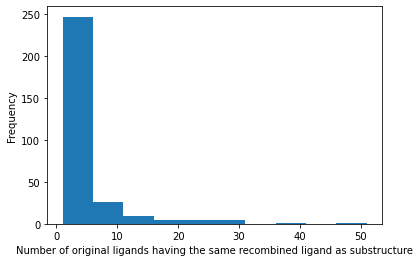

In [24]:
ax = recombined_in_original_size.plot(kind='hist')
ax.set_xlabel('Number of original ligands having the same recombined ligand as substructure')

### Draw recombined ligands that are most frequent substructures of original ligands

Number of original ligands with this substructure | recombined ligand index


/home/dominique/.local/miniforge3/envs/kinfraglib/lib/python3.6/site-packages/rdkit/Chem/Draw/IPythonConsole.py:188: UserWarning: Truncating the list of molecules to be displayed to 24. Change the maxMols value to display more.
  % (maxMols))


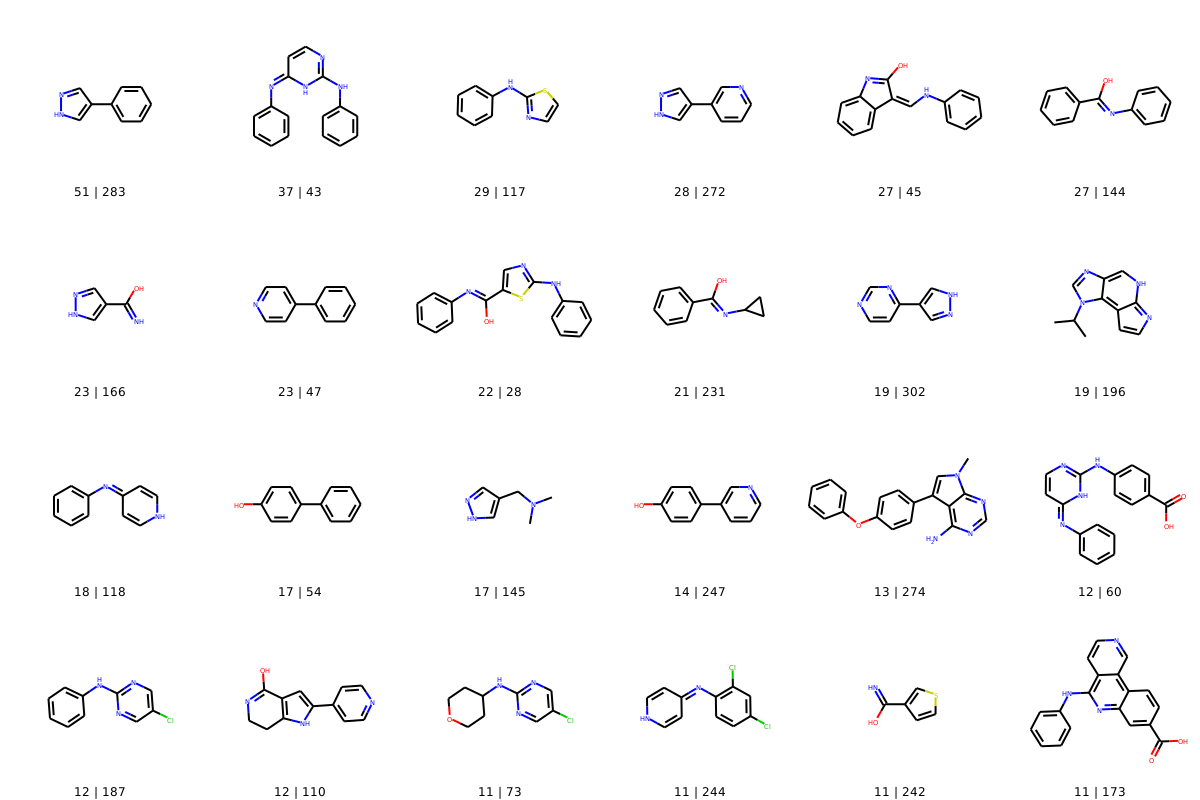

In [25]:
mols = []
legends = []

for index, size in recombined_in_original_size.sort_values(ascending=False).items():
    
    example_substructure = substructure_details[
        substructure_details.recombined_ligand_index == index
    ].iloc[0]
    
    mols.append(example_substructure.recombined_ligand)
    legends.append(f'{size} | {index}')
    
print(f'Number of original ligands with this substructure | recombined ligand index')
Draw.MolsToGridImage(mols=mols, legends=legends, molsPerRow=6, maxMols=24)